## Multistage and Multistep Demo

The code is written in [Julia](http://julialang.org).

This code is here to demonstrate how you use a "test problem" to setup and verify numerical methods.  It is a very important component of the whole process of developing and implementing numerical methods.

### A new nonlinear ODE:

Consider

$$ v'''(t) + v'(t) v(t) - \frac{\beta_1 + \beta_2 + \beta_3}{3} v'(t) =0, $$

where $\beta_1 < \beta_2 < \beta_3$.  It follows that
$$
v(t) = \beta_2 + (\beta_3 - \beta_2) \mathrm{cn}^2\left( \frac{\sqrt{ \beta_3 - \beta_1}}{12} t, \sqrt{\frac{\beta_3 - \beta_2}{\beta_3 - \beta_1}} \right)
$$
is a solution where $\mathrm{cn}(x,k)$ is the [Jacobi cosine function](https://en.wikipedia.org/wiki/Jacobi_elliptic_functions).  Some notations use $\mathrm{cn}(x,m)$ where $m = k^2$.  The second argument of the cn function is called the elliptic modulus.  The corresponding initial conditions are

$$
v(0) = \beta_3, \\
v'(0) = 0,\\
v''(0) = -\frac{(\beta_3 - \beta_1)(\beta_3-\beta_2)}{6}.$$

We first turn it into a system
$$
u_1'(t) =  v'(t) = u_2(t),\\
u_2'(t) = v''(t) = u_3(t),\\
u_3''(t) = \frac{\beta_1 + \beta_2 + \beta_3}{3} u_2(t) -  u_2(t)u_1(t).
$$

So, set $c = \frac{\beta_1 + \beta_2 + \beta_3)}{3}$
$$
f(u) = \begin{bmatrix} u_2 \\ u_3 \\ u_1(c - u_2)\end{bmatrix}.
$$

Because it will come back again, we have
$$
D_u f(u) = \begin{bmatrix} 0 & 1 & 0 \\
0 & 0 & 1 \\
-u_2  & c - u_1 & 0 \end{bmatrix}.
$$

In [1]:
using Plots

### Plotting the true solution

In `Julia` you need to call `using Pkg; Pkg.add("Elliptic")`

In [2]:
using Elliptic.Jacobi

In [3]:
β₁ = 0.
β₂ = 1.
β₃ = 10.
c = (β₁ + β₂ + β₃)/3
t = 0.:.01:10
v = t -> β₂ + (β₃ - β₂)*cn(sqrt((β₃-β₁)/12)*t, (β₃-β₂)/(β₃-β₁) )^2 # Julia uses the square of the elliptic modulus

#3 (generic function with 1 method)

In `Matlab` you'd use
```
v = @(t) b2 + (b3-b2)*jacobiCN(sqrt((b3-b1)/12)*t,(b3-b2)/(b3-b1))^2
```
and in `Python` you would use
```
from scipy.special import *
v = lambda t: b2 + (b3-b2)*ellipj(sqrt((b3-b1)/12)*t,(b3-b2)/(b3-b1))[1]**2
```

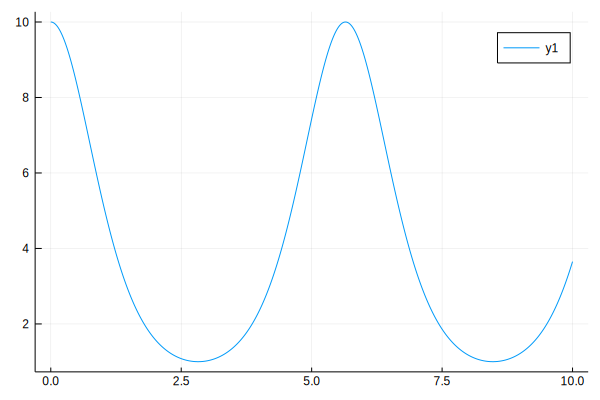

In [4]:
plot(t, map(v,t))

In [5]:
f = u -> [u[2], u[3], u[2]*(c - u[1])]
Df = u -> [0. 1. 0.; 0. 0. 1.; -u[2] c-u[1] 0.]
u₀ = [β₃,0.,-1.0/6*(β₃-β₁)*(β₃-β₂)]

3-element Array{Float64,1}:
  10.0              
   0.0              
 -14.999999999999998

In [6]:
h = 0.0001
[v(0), (v(h)-v(-h))/(2h), (v(h)-2v(0)+v(-h))/(h^2)]

3-element Array{Float64,1}:
  10.0              
   0.0              
 -15.000000175291461

In [7]:
T = 10.# Final time.
k = 0.0001 # Step size

0.0001

### Forward Euler

In [8]:
# Forward Euler
n = convert(Int64,ceil(T/k))# Number of time steps, converted to Int64
U = zeros(3,n+1) # To save the solution values
U[:,1] = u₀
t = zeros(n+1) # To save times
t[1] = 0.
for i = 2:n+1
    U[:,i] = U[:,i-1] + k*f(U[:,i-1])
    t[i] = t[i-1] + k
end

In [9]:
plot(t,U[1,:],label="Solution with Forward Euler")
plot!(t,map(v,t),label="True solution")

Even though the forward Euler method is not doing a good job, let's test its first-order accuracy.  While we have yet to discuss this in detail, we will see that first-order local truncation errors (plus stability) gives first-order convergence at a fixe time, say $t = 10$.

We decrease $k$ by a factor of $2$ each iteration:

In [10]:
T = 10. # Final time.
k = .02
p = 7
data = zeros(p)
ks = zeros(p)
for i = 1:p
    k = k/2
    n = convert(Int64,ceil(T/k))
    println("Number of time steps = ", n)
    U = zeros(3,n+1) # To save the solution values
    U[:,1] = u₀
    t = zeros(n+1,1)
    t[1] = 0.
    for i = 2:n+1
        U[:,i] = U[:,i-1] + k*f(U[:,i-1])
        t[i] = t[i-1] + k
    end
    data[i] = abs(U[1,end] - v(t[end]))
    ks[i] = k
end
data_fe = data

Number of time steps = 1000
Number of time steps = 2000
Number of time steps = 4000
Number of time steps = 8000
Number of time steps = 16000
Number of time steps = 32000
Number of time steps = 64000


7-element Array{Float64,1}:
 4.765943405224732  
 2.4835157036567233 
 1.2365055907962028 
 0.6127307338668069 
 0.3044443673615964 
 0.1516739069309181 
 0.07569136627506579

In [12]:
ks

7-element Array{Float64,1}:
 0.01      
 0.005     
 0.0025    
 0.00125   
 0.000625  
 0.0003125 
 0.00015625

As we can see, the error decreases as a factor of approximately $2$ each time $k$ is reduced by a factor of $2$.  This is first-order convergence.

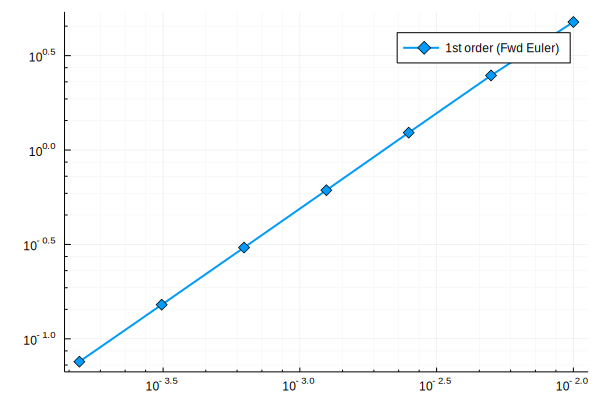

In [13]:
plot(ks,data,lw=2,ms=5,marker=:d, minorgrid = true, xaxis=:log, yaxis= :log,label="1st order (Fwd Euler)")

### Leapfrog (a 2-step method)

Note that starting with a first-order method still gives second-order convergence.

In [14]:
T = 10. # Final time.
k = .02
p = 7
data = zeros(p)
ks = zeros(p)
for i = 1:p
    k = k/2
    n = convert(Int64,ceil(T/k))
    println("Number of time steps = ", n)
    U = zeros(3,n+1) # To save the solution values
    U[:,1] = u₀
    t = zeros(n+1,1)
    t[1] = 0.
    U[:,2] = U[:,1] + k*f(U[:,1])  # Begin the method using
    t[2] = t[1] + k                # forward Euler
    for i = 3:n+1
        U[:,i] = U[:,i-2] + (2*k)*f(U[:,i-1]) #Leapfrog
        t[i] = t[i-1] + k
    end
    data[i] = abs(U[1,end] - v(t[end]))
    ks[i] = k
end
data_leap = data

Number of time steps = 1000
Number of time steps = 2000
Number of time steps = 4000
Number of time steps = 8000
Number of time steps = 16000
Number of time steps = 32000
Number of time steps = 64000


7-element Array{Float64,1}:
 260.11103070759196    
  28.183607367999528   
   4.30280791550914    
   0.9186856351290689  
   0.22031759572538734 
   0.054502857704748386
   0.013589811114453898

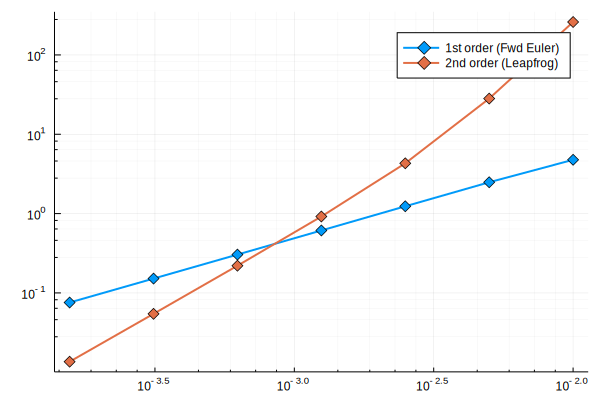

In [15]:
plot!(ks,data,lw=2,ms=5,marker=:d, minorgrid = true, xaxis=:log, yaxis= :log,label="2nd order (Leapfrog)")

## Trapezoid

At each time step we seek $U^{n+1}$ which solves

$$U^{n+1} - U^{n} = \frac{k}{2} \left( f(U^{n+1}) + f(U^{n}) \right).$$

So, we look for a zero of

$$ g(u,U^{n}) = u - U^{n} - \frac{k}{2} \left( f(u) + f(U^{n}) \right).$$

The Jacobian is given by

$$ D_u g(u) = I - \frac{k}{2} D_uf(u). $$

In Matlab and Python the identity matrix is constructed by `eye(n)`.  Julia handles the identity matrix in a different way.  When you add `eye(n) + A` Matlab has to add (possibly zero) to every entriy of `A`, $O(n^2)$ complexity. Julia does this by just adding to the diagonal using the `I` object, $O(n)$ complexity.

In [16]:
using LinearAlgebra

In [17]:
A = randn(3,3)

3×3 Array{Float64,2}:
 -1.22855   -1.22971    1.49252  
 -0.436659   1.30916   -0.598257 
 -1.08676    0.294905  -0.0177519

In [18]:
I

UniformScaling{Bool}
true*I

In [19]:
A + I # The "size" of I is inferred 

3×3 Array{Float64,2}:
 -0.228551  -1.22971    1.49252 
 -0.436659   2.30916   -0.598257
 -1.08676    0.294905   0.982248

In [20]:
Matrix{Float64}(I,2,2) # If you REALLY need to construct the identity matrix

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [21]:
A = randn(10000,10000)
@time I + A;
@time Matrix{Float64}(I,10000,10000) + A;

  0.580944 seconds (783 allocations: 762.986 MiB, 0.48% gc time)
  1.327579 seconds (383.29 k allocations: 1.508 GiB, 16.93% gc time)


In [22]:
g = (u,Un) -> u - Un - (k/2)*(f(u)+f(Un))
Dg = u -> I - (k/2)*Df(u)

#11 (generic function with 1 method)

In [23]:
T = 10 # Final time.
k = 0.02
p = 7
data = zeros(p)
ks = zeros(p)
for i = 1:p
    k = k/2
    n = convert(Int64,ceil(T/k))
    println("Number of time steps = ", n)
    U = zeros(3,n+1) # To save the solution values
    U[:,1] = u₀
    t = zeros(n+1,1)
    t[1] = 0.
    max_iter = 10
    for i = 2:n+1
        t[i] = t[i-1] + k
        Unew = U[:,i-1]
        Uold = U[:,i-1]
        for j = 1:max_iter
            Uold = Unew
            Unew = Uold - (Dg(Uold)\g(Uold,U[:,i-1]))
            if maximum(abs.(Unew-Uold)) < k^2/10 # Newton's method until error tol.
                break                            # Use k^2 because the method is second order
            end
            
            if j == max_iter
                println("Newton didn't terminate")
            end
            
        end
        U[:,i] = Unew
    end
    data[i] = abs(U[1,end] - v(t[end]))
    ks[i] = k
end
data_trap = data

Number of time steps = 1000
Number of time steps = 2000
Number of time steps = 4000
Number of time steps = 8000
Number of time steps = 16000
Number of time steps = 32000
Number of time steps = 64000


7-element Array{Float64,1}:
 0.05979524467763975   
 0.014963256565842187  
 0.003741691844107553  
 0.0009354774129111121 
 0.00023387275307618083
 5.846838844592028e-5  
 1.4617076749434688e-5 

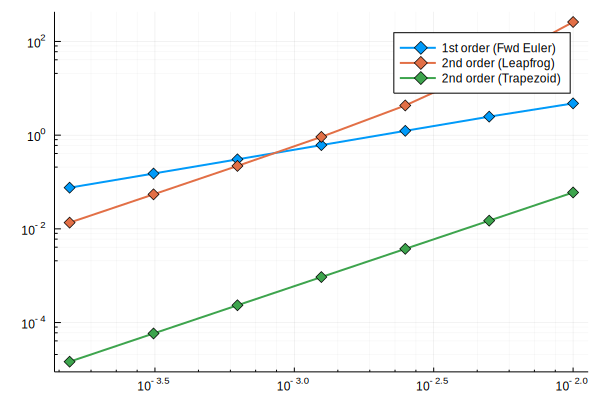

In [24]:
plot!(ks,data,lw=2,ms=5,marker=:d, minorgrid = true, xaxis=:log, yaxis= :log,label="2nd order (Trapezoid)")

## Two-step Adams-Moulton (AM) method

This method is given by 

$$ U^{n+2} = U^{n+1} + \frac{k}{12} \left( -f\left(U^n\right) + 8f\left(U^{n+1}\right) + 5f\left(U^{n+2}\right)\right). $$

Since this method is third order, we cannot start with Forward Euler as one step gives an error contribution of $O(k^2)$ which is, of course, much larger than the overall error of $O(k^3)$ that we expect. But we can start off with a second-order method.  Let's choose the 2-stage second order Runge-Kutta method. 

\begin{align*}
U^* &= U^n + \frac{k}{2} f(U^n),\\
U^{n+1} &= U^n + k f(U^*).
\end{align*}

Since this method is implicit, we need to set up our Jacobian for Newton's method:

In [25]:
g = (u,Un,Um) -> u - Un - (k/12)*(-f(Um)+8*f(Un)+5*f(u))
Dg = u -> I - (5k/12)*Df(u)

#15 (generic function with 1 method)

In [26]:
T = 10 # Final time.
k = .02
p = 7
data = zeros(p)
ks = zeros(p)
for i = 1:p
    k = k/2
    n = convert(Int64,ceil(T/k))
    println("Number of time steps = ", n)
    U = zeros(3,n+1) # To save the solution values
    U[:,1] = u₀
    t = zeros(n+1,1)
    t[1] = 0.
    max_iter = 10
    # Runge-Kutta second order here
    Us = U[:,1] + (k/2)*f(U[:,1])
    U[:,2] = U[:,1] + k*f(Us)
    t[2] = t[1] + k
    for i = 3:n+1
        t[i] = t[i-1] + k
        Unew = U[:,i-1]
        Uold = U[:,i-1]
        for j = 1:max_iter
            Uold = Unew
            Unew = Uold - (Dg(Uold)\g(Uold,U[:,i-1],U[:,i-2]))
            if maximum(abs.(Unew-Uold)) < k^3/100 # Newton's method until error tol.
                break                            # Use k^3 because the method is third order
            end
            
            if j == max_iter
                println("Newton didn't terminate")
            end
            
        end
        U[:,i] = Unew
    end
    data[i] = abs(U[1,end] - v(t[end]))
    ks[i] = k
end
data_am = data

Number of time steps = 1000
Number of time steps = 2000
Number of time steps = 4000
Number of time steps = 8000
Number of time steps = 16000
Number of time steps = 32000
Number of time steps = 64000


7-element Array{Float64,1}:
 7.24244403431662e-5   
 1.1293999918393638e-5 
 1.551785251852067e-6  
 2.0273875112053474e-7 
 2.5891308208514374e-8 
 3.261991565750577e-9  
 3.7915626194262586e-10

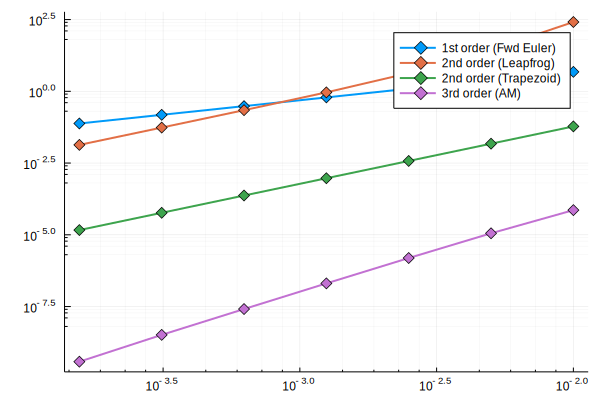

In [27]:
plot!(ks,data,lw=2,ms=5,marker=:d, minorgrid = true, xaxis=:log, yaxis= :log,label="3rd order (AM)")

### 4th-order Runge-Kutta (explicit, Example 5.13)

In [28]:
T = 10 # Final time.
k = .02
p = 7
data = zeros(p)
ks = zeros(p)
for i = 1:p
    k = k/2
    n = convert(Int64,ceil(T/k))
    println("Number of time steps = ", n)
    U = zeros(3,n+1) # To save the solution values
    U[:,1] = u₀
    t = zeros(n+1,1)
    t[1] = 0.
    max_iter = 10
    for i = 2:n+1
        t[i] = t[i-1] + k
        Y1 = U[:,i-1]
        f1 = f(Y1)    
        Y2 = U[:,i-1] + (k/2)*f1
        f2 = f(Y2)
        Y3 = U[:,i-1] + (k/2)*f2
        f3 = f(Y3)
        Y4 = U[:,i-1] + k*f3
        f4 = f(Y4)
        U[:,i] = U[:,i-1] + (k/6)*(f1+2*f2+2*f3+f4)
    end
    data[i] = abs(U[1,end] - v(t[end]))
    ks[i] = k
end
data_rk = data

Number of time steps = 1000
Number of time steps = 2000
Number of time steps = 4000
Number of time steps = 8000
Number of time steps = 16000
Number of time steps = 32000
Number of time steps = 64000


7-element Array{Float64,1}:
 9.302531838173422e-7  
 5.824521087660628e-8  
 3.6395140234901646e-9 
 2.2439561320197754e-10
 1.6505463662497277e-11
 3.707301132749308e-11 
 1.319389042464536e-11 

In [31]:
1e-11/64000

1.5625e-16

In [33]:
2.2e-16*64000

1.408e-11

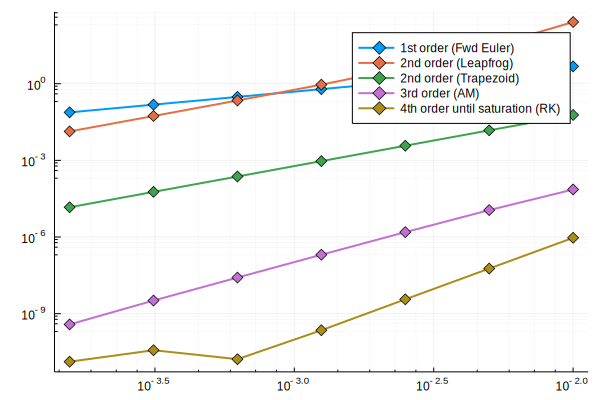

In [29]:
plot!(ks,data,lw=2,ms=5,marker=:d, minorgrid = true, xaxis=:log, yaxis= :log,label="4th order until saturation (RK)")

In [38]:
methods = ["Forward Euler","Leapfrog","Trapezoid","Adams-Moulton","Runge-Kutta"];
d = Dict([(methods[1],data_fe),(methods[2],data_leap),(methods[3],data_trap),(methods[4],data_am),(methods[5],data_rk)]) # Use a dictionary, because we can

Dict{String,Array{Float64,1}} with 5 entries:
  "Trapezoid"     => [0.0597952, 0.0149633, 0.00374169, 0.000935477, 0.00023387…
  "Adams-Moulton" => [7.24244e-5, 1.1294e-5, 1.55179e-6, 2.02739e-7, 2.58913e-8…
  "Leapfrog"      => [260.111, 28.1836, 4.30281, 0.918686, 0.220318, 0.0545029,…
  "Runge-Kutta"   => [9.30253e-7, 5.82452e-8, 3.63951e-9, 2.24396e-10, 1.65055e…
  "Forward Euler" => [4.76594, 2.48352, 1.23651, 0.612731, 0.304444, 0.151674, …

In [39]:
data_table = Array{Any,2}(undef,7,6);
data_table[1,1] = "k"
data_table[1,2:end] = methods # create column headings
for j = 2:7
    data_table[j,1] = ks[j]
end
l = 1
for i in methods
    l += 1
    for j = 2:7
        data_table[j,l] = d[i][j-1]/d[i][j]
    end
end

### This gives the error reduction ratio: 

$$\frac{\text{Error with time step } 2k}{\text{Error with time step } k}$$

For an $r$th-order method we should see this be approximately $2^r$.

In [40]:
using Printf

In [41]:
@printf("%s        | %s |  %s |  %s |  %s  | %s \n",data_table[1,:]...)
for j=2:7
    @printf("%f | %0.4f        |  %0.4f   |  %0.4f    |  %0.4f         | %0.4f \n",data_table[j,:]...)
end

k        | Forward Euler |  Leapfrog |  Trapezoid |  Adams-Moulton  | Runge-Kutta 
0.005000 | 1.9190        |  9.2292   |  3.9961    |  6.4126         | 15.9713 
0.002500 | 2.0085        |  6.5501   |  3.9991    |  7.2781         | 16.0036 
0.001250 | 2.0180        |  4.6837   |  3.9998    |  7.6541         | 16.2192 
0.000625 | 2.0126        |  4.1698   |  3.9999    |  7.8304         | 13.5952 
0.000313 | 2.0072        |  4.0423   |  4.0000    |  7.9373         | 0.4452 
0.000156 | 2.0038        |  4.0106   |  4.0000    |  8.6033         | 2.8099 
